In [1]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

CPU times: user 2.5 s, sys: 243 ms, total: 2.75 s
Wall time: 3.28 s


In [2]:
df = pd.read_excel('final.xlsx')
df.columns

Index(['text', 'label'], dtype='object')

In [3]:
df.head()

,text,label
0,it's amazing that no matter how hard you try t...,1
1,It's quite heartbreaking to see some of my clo...,1
2,please stop telling me u love me- the words th...,1
3,Why do people say they know me when they don't...,1
4,You took a knife and stabbed it straight throu...,1


In [4]:
df['label'].value_counts()

0    5434
1    1096
Name: label, dtype: int64

In [5]:
df.isnull().sum()

text     10
label     0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.shape

(6520, 2)

In [8]:
df.head()

,text,label
0,it's amazing that no matter how hard you try t...,1
1,It's quite heartbreaking to see some of my clo...,1
2,please stop telling me u love me- the words th...,1
3,Why do people say they know me when they don't...,1
4,You took a knife and stabbed it straight throu...,1


In [9]:
df_n = df.sample(frac=1)
df_n.head()

,text,label
826,You should carry on,0
2391,make it easy,0
6332,just woke up hehe,0
5692,Just woke up,0
1608,What's trending is wrong or not?,0


In [10]:
import string
import nltk

def text_transformation(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [11]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    stopword = stopwords.words('english')
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopword]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(filtered_words)

In [12]:
df_n['cleaned'] = df['text'].apply(text_transformation)

In [13]:
df_n

,text,label,cleaned
826,You should carry on,0,you should carry on
2391,make it easy,0,make it easy
6332,just woke up hehe,0,just woke up hehe
5692,Just woke up,0,just woke up
1608,What's trending is wrong or not?,0,what s trending is wrong or not
...,...,...,...
784,How u doin?,0,how u doin
1524,"When you're not fasting, what do you want to e...",0,when you re not fasting what do you want to e...
3348,Hi! Buddy,0,hi buddy
1147,"Seriously, people who are in love are having a...",0,seriously people who are in love are having a...


In [14]:
df_n.tail()

,text,label,cleaned
784,How u doin?,0,how u doin
1524,"When you're not fasting, what do you want to e...",0,when you re not fasting what do you want to e...
3348,Hi! Buddy,0,hi buddy
1147,"Seriously, people who are in love are having a...",0,seriously people who are in love are having a...
3885,Don’t give someone false hope.,0,don t give someone false hope


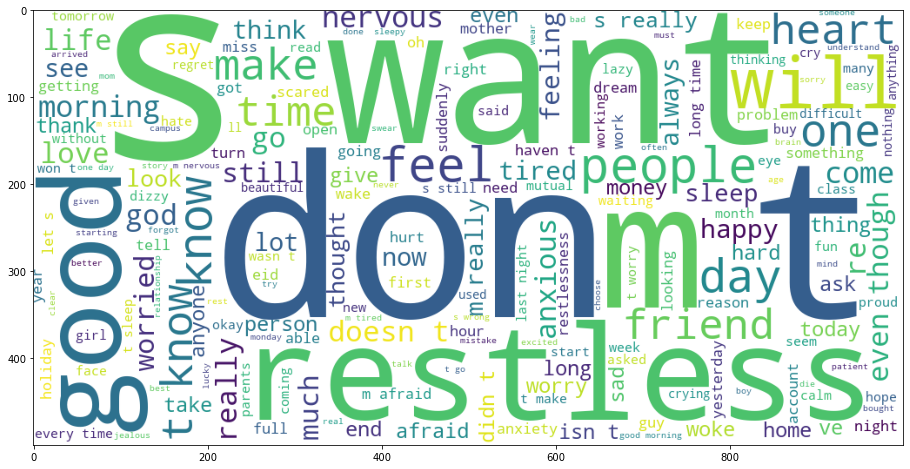

In [15]:
from wordcloud import WordCloud
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in df_n['cleaned']:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 6).generate(word_cloud)
plt.imshow(wordcloud)

In [16]:
%%time
max_words = 10000

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token=None, document_count=0)

tokenizer.fit_on_texts(df_n['cleaned'])

CPU times: user 99.5 ms, sys: 3.94 ms, total: 103 ms
Wall time: 103 ms


In [17]:
%%time
word_counts = tokenizer.word_counts
word_docs = tokenizer.word_docs
word_index = tokenizer.word_index
document_count = tokenizer.document_count

print(len(word_counts))

3239
CPU times: user 1.26 ms, sys: 0 ns, total: 1.26 ms
Wall time: 733 µs


Frequency Distribution

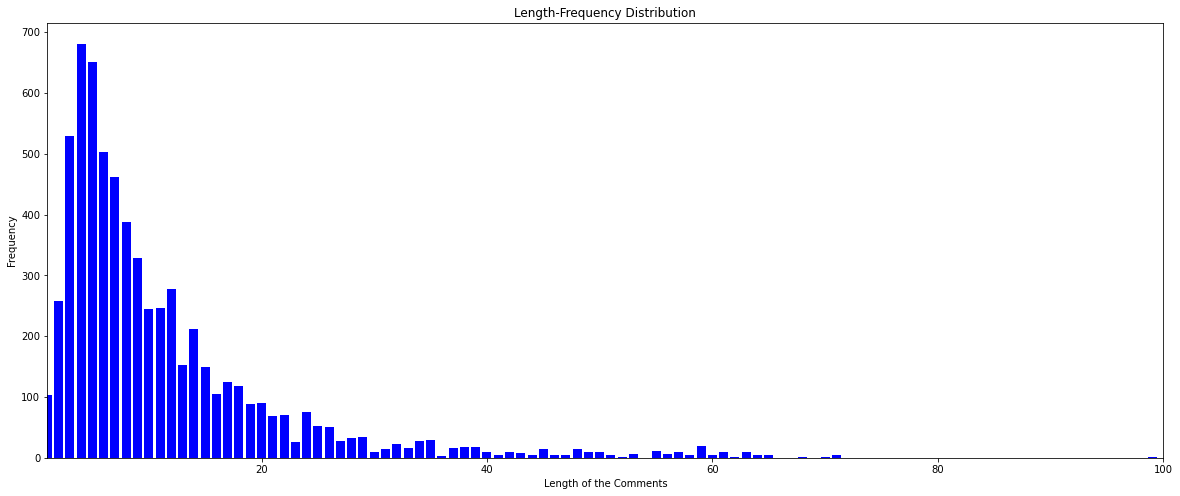

Maximum Length of a Comment: 335
Minimum Length of a Comment: 1
Average Length of a Comment: 11.0


In [18]:
df_n['Comment_Length'] = df_n.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in df_n.Comment_Length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 100)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Comments')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a Comment: {max(df_n.Comment_Length)}")
print(f"Minimum Length of a Comment: {min(df_n.Comment_Length)}")
print(f"Average Length of a Comment: {round(np.mean(df_n.Comment_Length),0)}")

In [19]:
df_n[df_n['Comment_Length'] == 335]

,text,label,cleaned,Comment_Length
1,It's quite heartbreaking to see some of my clo...,1,it s quite heartbreaking to see some of my clo...,335


In [20]:
sequences = tokenizer.texts_to_sequences(df_n['cleaned'])

In [21]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(df_n['cleaned'][0])
print()
print(sequences[0])


Found 3239 unique tokens.
it s amazing that no matter how hard you try to get them to know your hurting they just don t look past the fake smile and the fake laughter    miss you papa   

[4, 248, 960, 50]


In [22]:
%%time
## Before padding length of different training examples 
mx = len(sequences[0])
for x in sequences:
  mx =max(mx, len(x))
print("Maximum Review length",mx)

##We can also determine maxlen by plotting the frequency distribution of the lengths
corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0, padding='post', maxlen= 60)
## We get the maxlen value from the Length frequency distribution

print(corpus[1])

Maximum Review length 335
[ 69   6 324   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
CPU times: user 51.7 ms, sys: 4.55 ms, total: 56.3 ms
Wall time: 47.2 ms


In [23]:
print("Shape of the courpus: ", corpus.shape)

for i in range(2):
    print(df_n['cleaned'][i],"\n",corpus[i])

Shape of the courpus:  (6520, 60)
it s amazing that no matter how hard you try to get them to know your hurting they just don t look past the fake smile and the fake laughter    miss you papa    
 [  4 248 960  50   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
it s quite heartbreaking to see some of my closest friends whom i have adored a lot all throughout my varsity life signing off from the campus  it hurts a lot thinking about not roaming around the campus with them or not being able to find them after the graduation anymore  my campus life hasn t been a smooth journey  it has seen ups   downs  the people with whom i had been close in the first year or  year hadn t been there all the way to the end  but some people being there even in dire need at the end will never be written off from my memories  i hav

In [24]:
from keras.utils import to_categorical
y = to_categorical(df_n.label)
X_train,X_test,y_train,y_test = train_test_split(corpus,y,test_size = 0.2, random_state = 0)

print("Training Size: ",X_train.shape)
print("Test Size: ",X_test.shape)

Training Size:  (5216, 60)
Test Size:  (1304, 60)


BiLSTM

In [25]:
import keras.backend as K 
from keras.models import Sequential
from keras.layers import Flatten,Dense,Bidirectional,LSTM,GRU,Embedding
from keras.preprocessing.sequence import pad_sequences

In [26]:
K.clear_session()

In [27]:
maxlen = 50

In [28]:
corpus

array([[  4, 248, 960, ...,   0,   0,   0],
       [ 69,   6, 324, ...,   0,   0,   0],
       [ 29, 157,  38, ...,   0,   0,   0],
       ...,
       [291, 150,   0, ...,   0,   0,   0],
       [352,  49,  45, ...,   0,   0,   0],
       [ 19,   8, 131, ...,   0,   0,   0]], dtype=int32)

In [29]:
vocab_size = len(tokenizer.word_index) + 1
word_counts = tokenizer.word_counts

In [30]:
embedding_dim = 100
accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
  # Saved the Best Model
filepath = "BiLSTM_no.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
  # callback list
callback_list = [acc_callback, checkpoint] 

In [31]:
model = tf.keras.Sequential([
    Embedding(max_words, embedding_dim, input_length = maxlen, trainable=False),
    Bidirectional(LSTM(64,dropout=0.2)),
    Dense(24, activation='relu'),
    Flatten(),
    Dense(2, activation='softmax')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 50        
Total params: 1,087,626
Trainable params: 87,626
Non-trainable params: 1,000,000
_________________________________________________________________


In [32]:
history = model.fit(X_train,y_train,
                    epochs = 20,
                    batch_size = 32,
                    verbose = 1,
                    validation_split =0.1,
                    callbacks = callback_list
                    )

Epoch 1/20
147/147 [==============================] - 10s 41ms/step - loss: 0.5231 - accuracy: 0.8110 - val_loss: 0.4172 - val_accuracy: 0.8276

Epoch 00001: val_accuracy improved from -inf to 0.82759, saving model to BiLSTM_no.h5
Epoch 2/20
147/147 [==============================] - 5s 34ms/step - loss: 0.4519 - accuracy: 0.8173 - val_loss: 0.4182 - val_accuracy: 0.8276

Epoch 00002: val_accuracy did not improve from 0.82759
Epoch 3/20
147/147 [==============================] - 5s 33ms/step - loss: 0.4154 - accuracy: 0.8306 - val_loss: 0.3854 - val_accuracy: 0.8295

Epoch 00003: val_accuracy improved from 0.82759 to 0.82950, saving model to BiLSTM_no.h5
Epoch 4/20
147/147 [==============================] - 5s 35ms/step - loss: 0.4046 - accuracy: 0.8284 - val_loss: 0.3489 - val_accuracy: 0.8582

Epoch 00004: val_accuracy improved from 0.82950 to 0.85824, saving model to BiLSTM_no.h5
Epoch 5/20
147/147 [==============================] - 5s 36ms/step - loss: 0.3413 - accuracy: 0.8662 - v

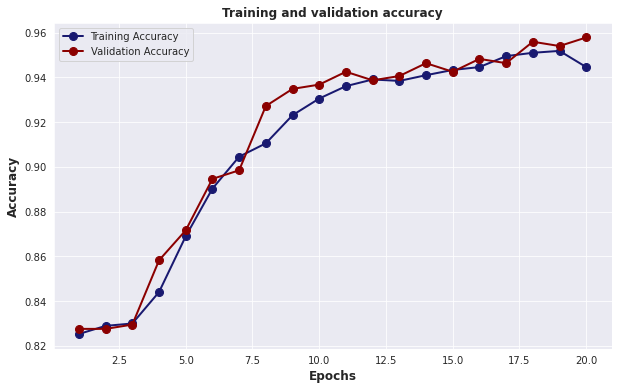

In [41]:
import seaborn as sns
plt.figure(figsize=(10,6))
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')
                  #=========================================================
                  ############### Epochs vs Validation Accuracy Plot ##########
                  #==========================================================

plt.plot(epochs, acc, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
plt.legend(['Training Accuracy','Validation Accuracy'])

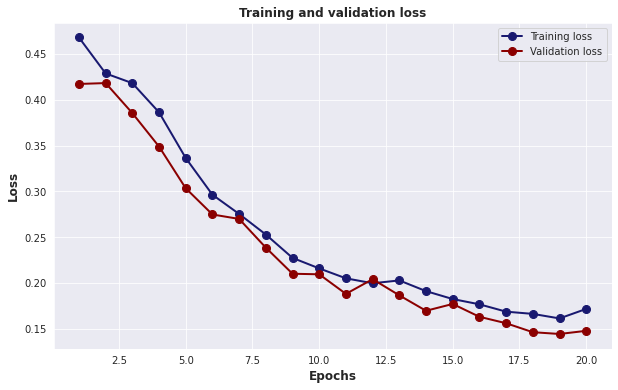

In [43]:
plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training loss')
plt.plot(epochs, val_loss_values, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training loss')
plt.title('Training and validation loss',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Loss',fontsize=12,fontweight='bold')
plt.legend(['Training loss','Validation loss'])

In [35]:
from keras.models import load_model
loaded_model = load_model("BiLSTM_no.h5")

In [36]:
X_train,X_test,y_train,y_test = train_test_split(corpus,df_n.label,test_size = 0.2,random_state = 42)

In [37]:
y_pred = np.argmax(loaded_model.predict(X_test), axis=-1)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.97      1069
           1       0.97      0.79      0.87       235

    accuracy                           0.96      1304
   macro avg       0.96      0.89      0.92      1304
weighted avg       0.96      0.96      0.96      1304



<AxesSubplot:>

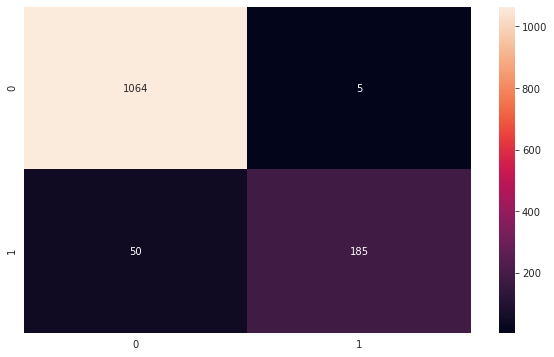

In [40]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True,fmt='d')